In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from functools import reduce
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_roc_curve,plot_confusion_matrix, accuracy_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


In [139]:
#load feature_data
X = pd.read_csv("feature_data.csv")
#load_label_data
y = pd.read_csv("label_data.csv")
#change_column_names
X = X.rename(columns = {'Unnamed: 0':'id'})
y = y.rename(columns = {'Unnamed: 0':'id'})
#split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,random_state = 42,shuffle = True)
#merge_data
new_df=pd.merge(X_train,y_train,on=['id'])
new_df.head()

,id,time_until_order,order_year,order_month,order_week,order_day_of_month,adults,children,babies,country,...,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11,anon_feat_12,anon_feat_13,cancelation
0,32696,5.0,2017,January,week_5,30,2,2.0,0,MAR,...,6.0,0.0,1.0,0,1.0,0.502086,2.050217,True,0.0,False
1,27250,127.0,2017,August,week_33,18,2,0.0,0,PRT,...,4.0,0.0,NaN,4,1.0,0.444252,11.344172,False,NaN,False
2,84393,22.0,2016,February,week_9,22,2,0.0,0,PRT,...,3.0,0.0,0.0,1,NaN,0.551103,4.793369,False,NaN,False
3,109652,NaN,2017,April,week_15,9,2,0.0,0,GBR,...,0.0,0.0,0.0,1,0.0,0.319022,10.610277,False,NaN,False
4,116988,NaN,2017,July,week_30,25,3,0.0,0,FRA,...,3.0,0.0,1.0,0,0.0,0.492604,14.314214,True,0.0,False


In [140]:
#basic data info
print(new_df.shape)
new_df.info()

(67156, 35)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 67156 entries, 0 to 67155
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   67156 non-null  int64  
 1   time_until_order     57706 non-null  float64
 2   order_year           67156 non-null  int64  
 3   order_month          64546 non-null  object 
 4   order_week           67156 non-null  object 
 5   order_day_of_month   67156 non-null  int64  
 6   adults               67156 non-null  int64  
 7   children             67152 non-null  float64
 8   babies               67156 non-null  int64  
 9   country              63915 non-null  object 
 10  order_type           67156 non-null  object 
 11  acquisition_channel  67156 non-null  object 
 12  prev_canceled        67156 non-null  int64  
 13  prev_not_canceled    67156 non-null  int64  
 14  changes              64561 non-null  float64
 15  deposit_type         603

In [141]:
#empty_val_stats - 
new_df.isnull().sum()
total = new_df.isnull().sum()
percent_missing = new_df.isnull().sum() * 100 / len(new_df)
missing_value_df = pd.DataFrame({'total': total,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

#note: we can restore NA values of 'month' from corresponding 'week', which indicates they have strong
# corelation and we can maybe exclude one of them

,total,percent_missing
company,63360,94.347489
anon_feat_13,62850,93.588064
time_until_order,9450,14.071714
agent,9163,13.644350
customer_type,7384,10.995295
deposit_type,6783,10.100363
anon_feat_11,3696,5.503604
country,3241,4.826077
anon_feat_6,3157,4.700995
anon_feat_7,3149,4.689082


# Numerical and categorial features

In [142]:
#Split numerical and categorial data
X_num = X_train.select_dtypes(include=[np.number])
X_categ = X_train.select_dtypes(exclude=[np.number])
print ('number of categorical features: ' ,len(X_categ.columns))
c= X_categ.copy()

number of categorical features:  8


## handeling catecorial fetures

In [143]:

# we can easily deal with 'order_month','order_week' by converting them to their corresponding numbers,
# and 'anon_feat_12' to binary values
months = {'January':1,'February':2,'March':3,'April': 4,'May': 5,'June': 6,'July': 7,'August': 8,'September': 9,'October': 10,'November': 11,'December': 12}
c['order_month'].replace(months, inplace=True)
c['order_week'] = c['order_week'].str.slice(start=5).apply(pd.to_numeric)
c['order_month'].fillna((c['order_week']/4.3).apply(np.ceil), inplace = True)  #calc month for NA values from week, this isn't precise
c['anon_feat_12'] = c['anon_feat_12'].astype(int)

# we will probable want to use get_dummies for those, for now i'm changing it so we can take a look at correlations with lables
order_t = {'Offline TA/TO':1,'Online TA':2,'Direct':3,'Corporate':4,'Groups':5,'Aviation':6,'Complementary':7,'Undefined':8}
c['order_type'].replace(order_t, inplace=True)
acq_c = {'TA/TO':1,'GDS':2,'Direct':3,'Corporate':4,'Undefined':5}
c['acquisition_channel'].replace(acq_c, inplace=True)
dep = {'No Deposit':1,'Non Refund':2,'Refundable':3}
c['deposit_type'].replace(dep, inplace=True)
cus_t = {'Transient-Party':1,'Transient':2,'Contract':3,'Group':4}
c['customer_type'].replace(cus_t, inplace=True)
c.info()
#joining data to numerical dataframe
#for now, I didn't handle Country so I didn't add it

X_num = X_num.join(c.drop('country', axis=1))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 67156 entries, 72578 to 15795
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   order_month          67156 non-null  float64
 1   order_week           67156 non-null  int64  
 2   country              63915 non-null  object 
 3   order_type           67156 non-null  int64  
 4   acquisition_channel  67156 non-null  int64  
 5   deposit_type         60373 non-null  float64
 6   customer_type        59772 non-null  float64
 7   anon_feat_12         67156 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 4.6+ MB


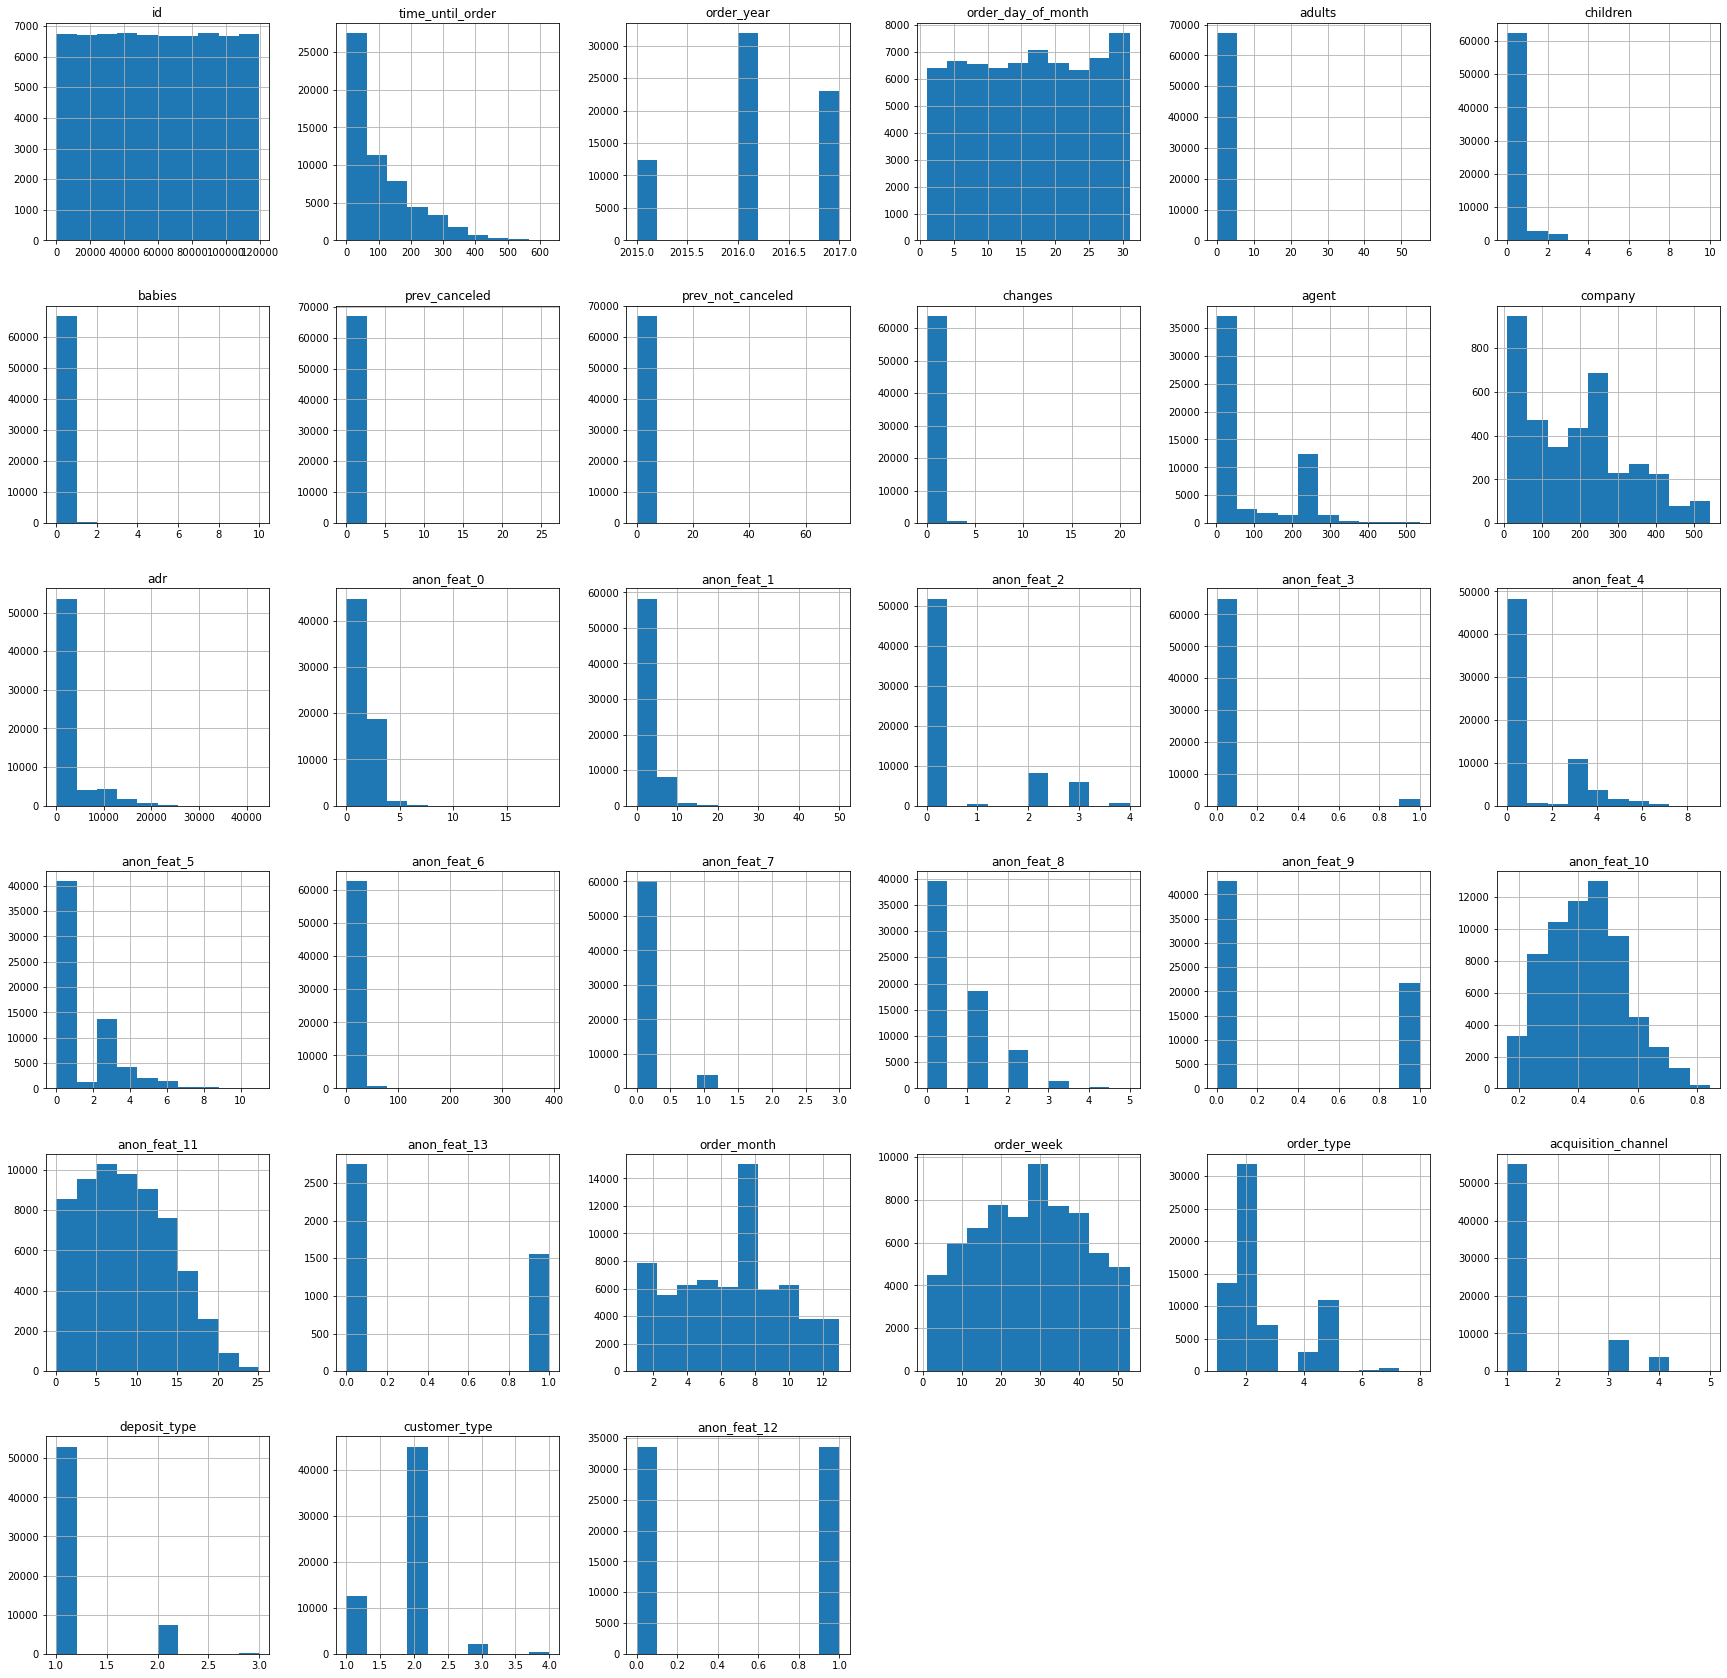

In [144]:
#Feature_histogram
X_num.hist(figsize=(30,30))
plt.show()

# some initial conclusions:
# outlayers:
# 1. we will probably want to handle ['adults','children','babies','adr','annot_feat_0-1,6']
# 2. maybe we won't touch these features? because we can get the intuition that these outlayers will be important?
# ['prev_not_canceled',prev_canceled','changes','','']
# normalization = ['']?
# log = ['time_until_order']?

<AxesSubplot:>

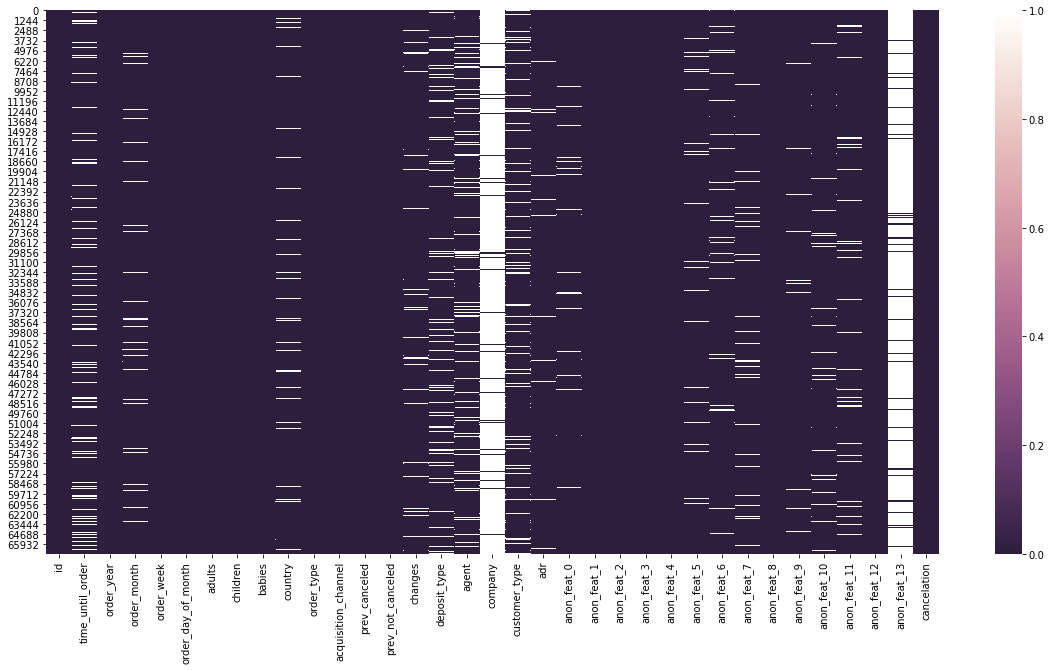

In [145]:
#plot null values per row
%matplotlib inline
plt.figure(figsize=(20, 10))
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
sns.heatmap(new_df.isnull(), cmap=cmap)

In [146]:
#columns we might want to drop due to multyple NA ['company','anon_feat_13']


# Correlations w/o lables

In [147]:
# we need to decide if to fillna before we do correlation heatmap or after
# fix categorial vs numerical
# fillna according to outliers in numerical - mean/median
# outliers visulaization - boxplot
# correlation heatmap
# pca

#features thoughts:
#agent - maybe its also categorial?

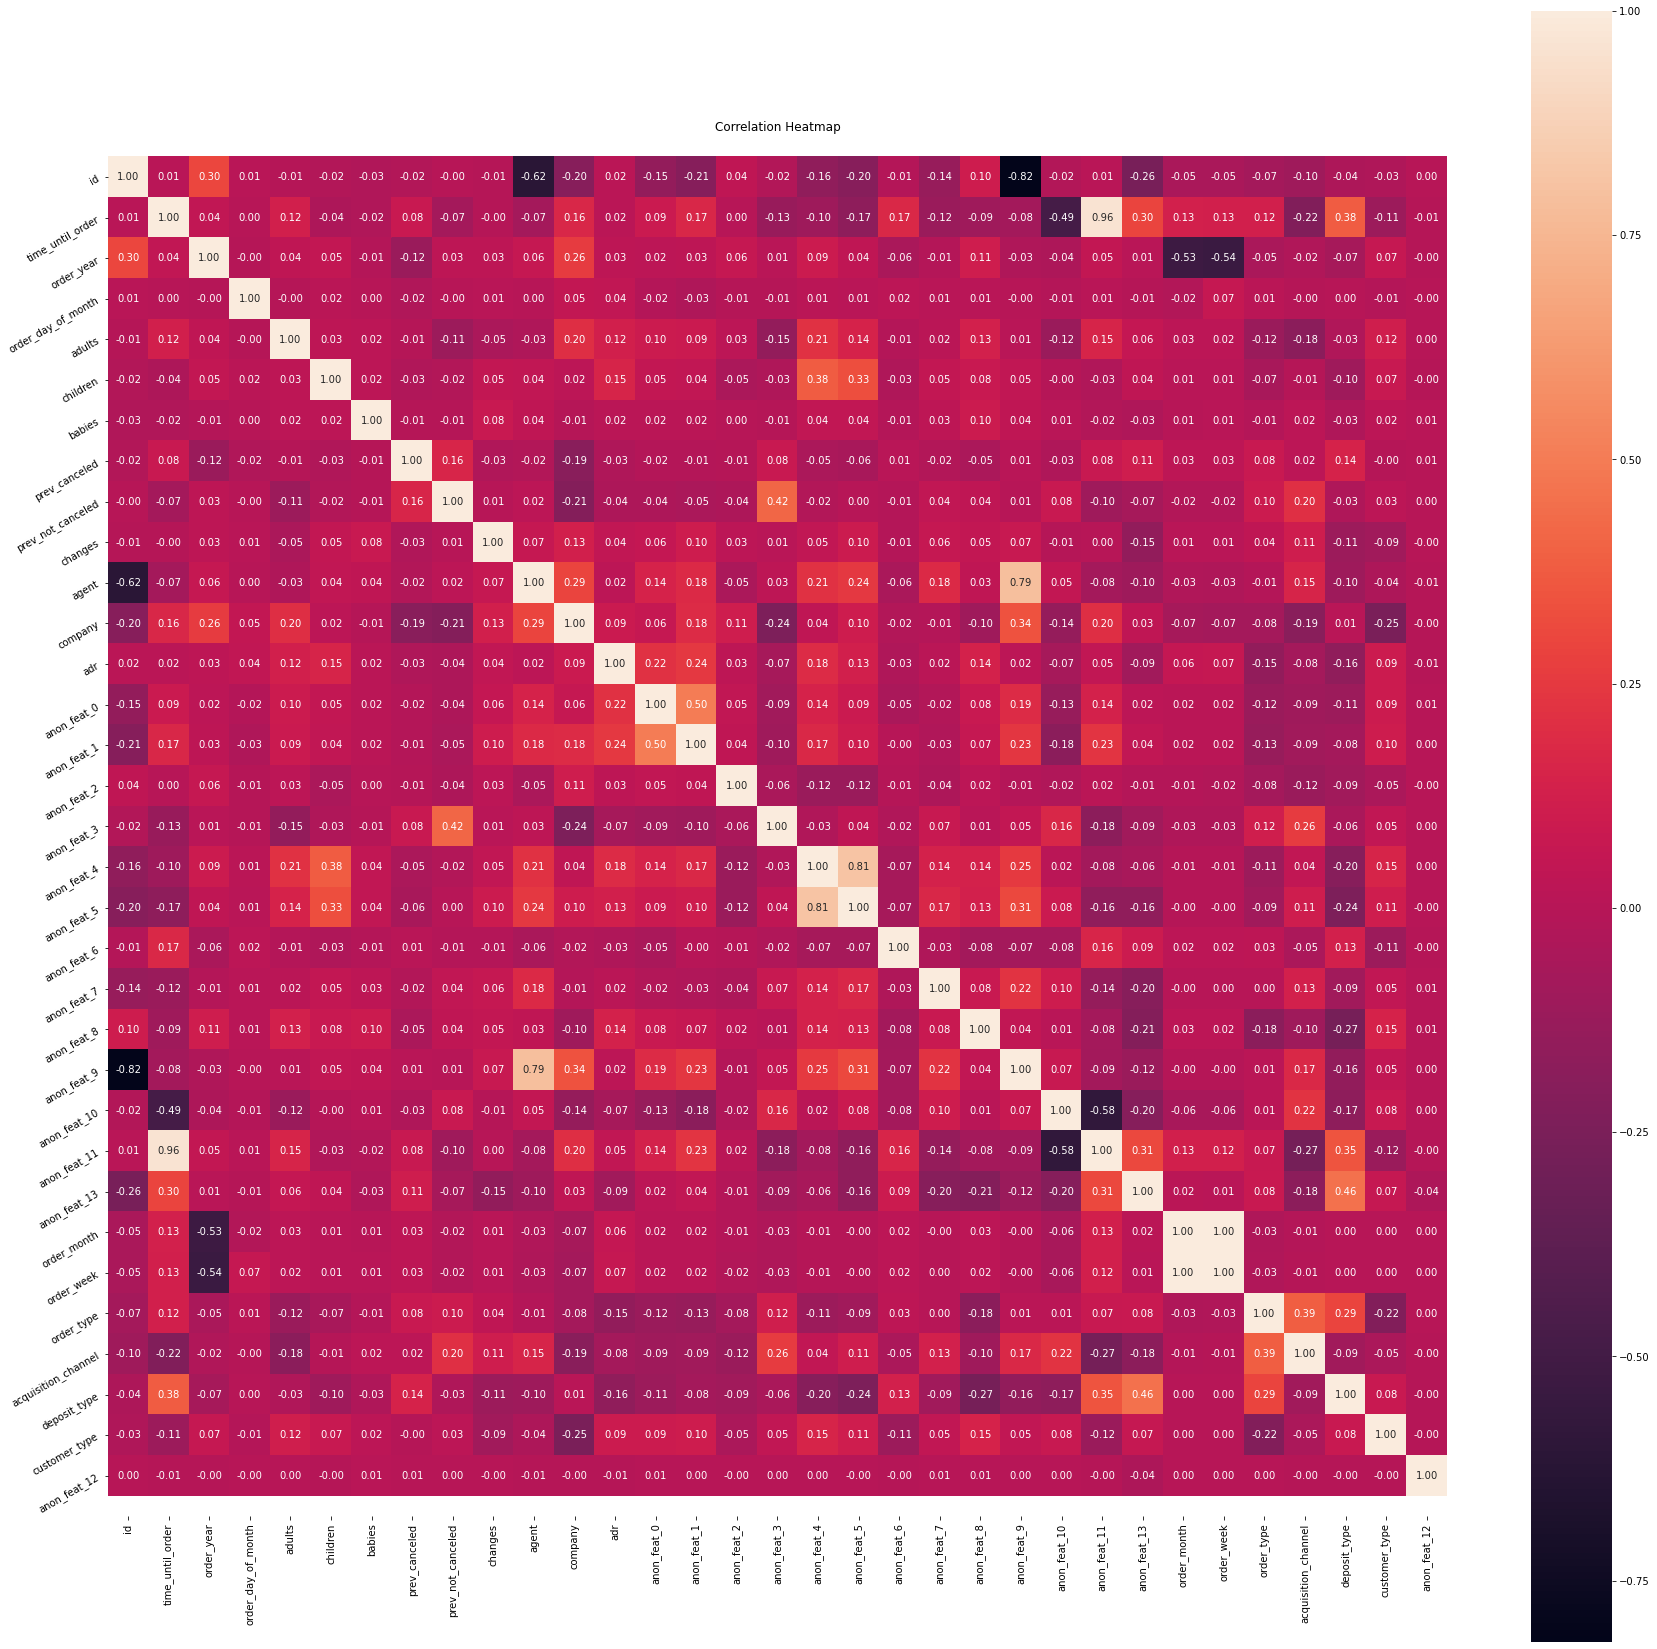

In [148]:
correlation = X_num.corr()
plt.figure(figsize=(30,30))
plt.title('Correlation Heatmap')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)                 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

# We see high correlation between time_until_order to anon_feat_11
# We see high correlation between agent and anon_feat_9
# We see high correlation between anon_feat_4 and anon_feat_5
# We see low correlation between anon_feat_10 and anon_feat_11

# creating new features

In [149]:
X_num['cancelation_percentage'] = X_num['prev_canceled']/(X_num['prev_canceled']+X_num['prev_not_canceled'])
X_num['cancelation_percentage'].fillna(0, inplace = True)

# Correlations with lables

In [150]:
X_num.corrwith(y['cancelation']).sort_values(ascending=False)

anon_feat_13              1.000000
deposit_type              0.465093
anon_feat_11              0.312541
time_until_order          0.292467
cancelation_percentage    0.290626
order_type                0.111057
prev_canceled             0.108540
customer_type             0.084831
anon_feat_6               0.058195
adults                    0.056654
anon_feat_1               0.027683
order_month               0.014931
order_year                0.014521
order_week                0.012003
children                  0.005075
anon_feat_0              -0.000334
anon_feat_12             -0.007302
order_day_of_month       -0.009336
anon_feat_2              -0.016290
company                  -0.019220
babies                   -0.032507
prev_not_canceled        -0.060029
anon_feat_4              -0.061918
adr                      -0.070128
agent                    -0.081958
anon_feat_3              -0.088319
anon_feat_9              -0.136613
changes                  -0.143720
acquisition_channel 

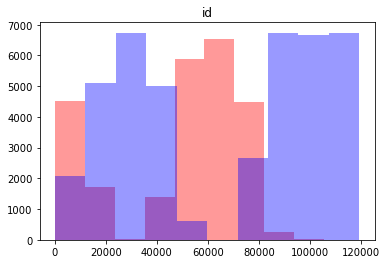

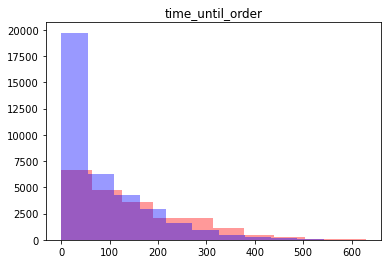

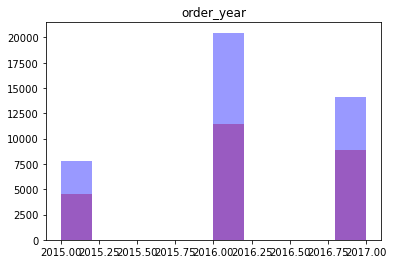

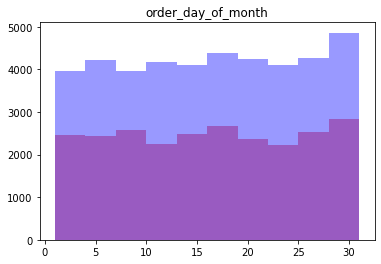

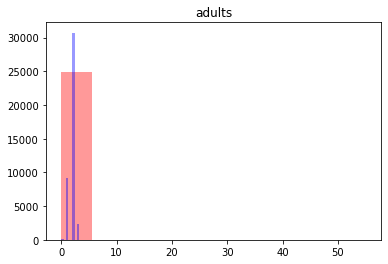

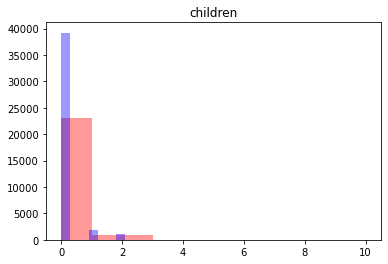

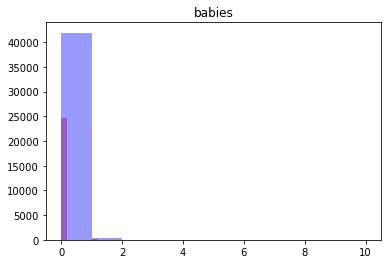

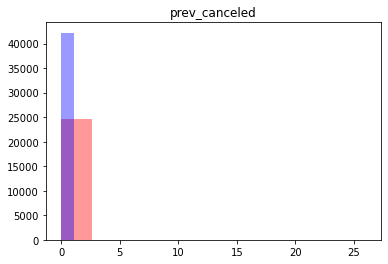

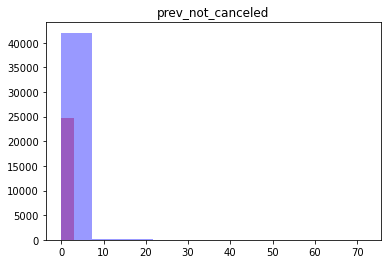

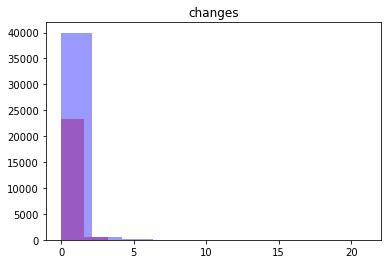

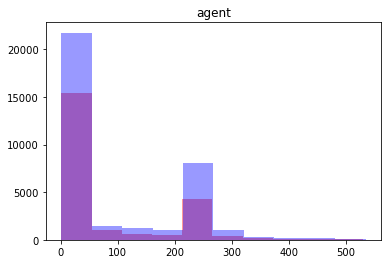

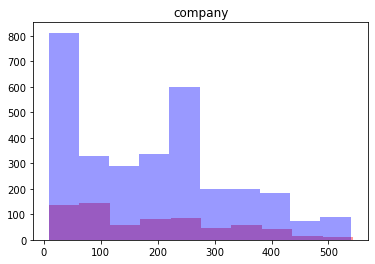

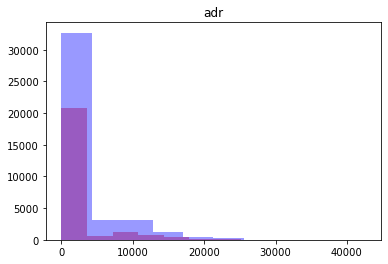

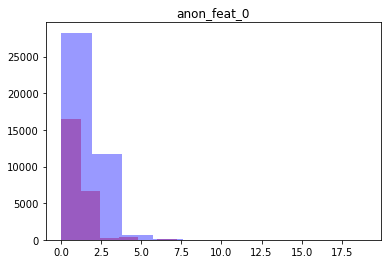

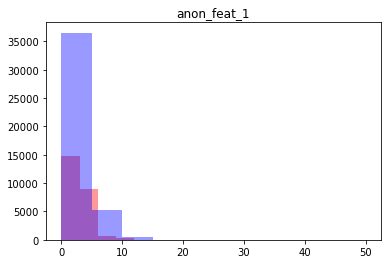

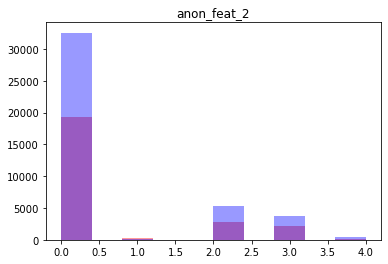

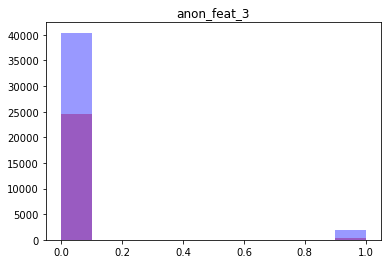

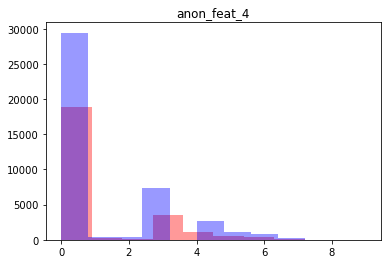

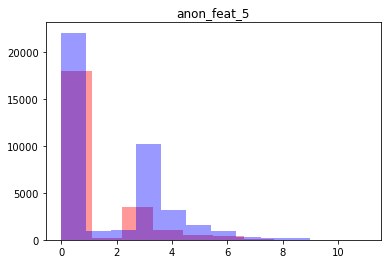

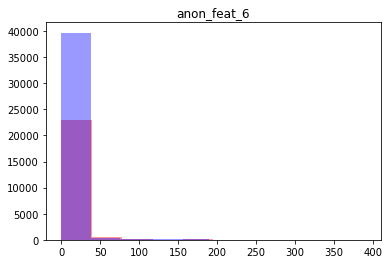

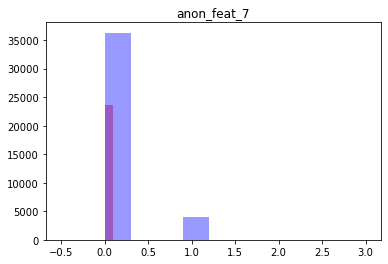

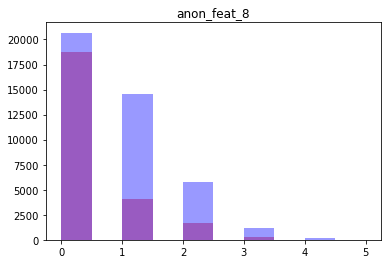

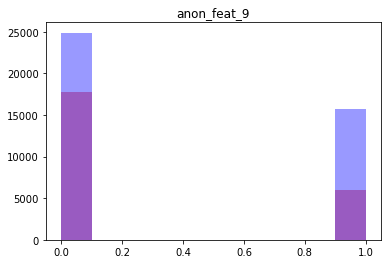

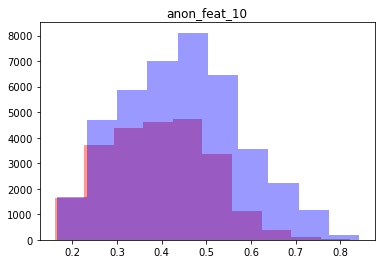

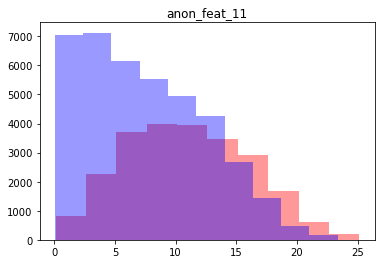

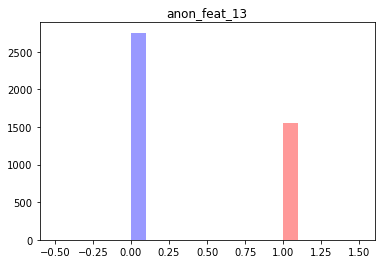

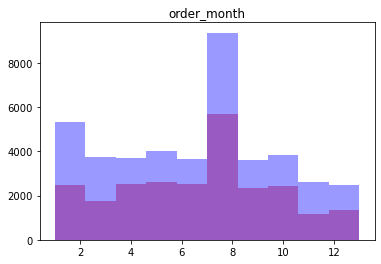

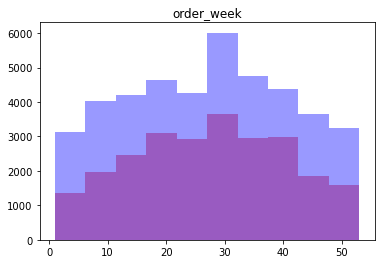

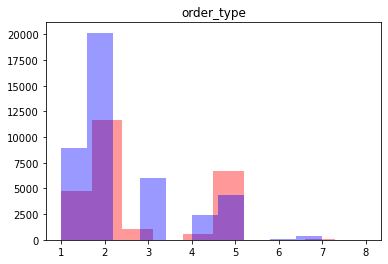

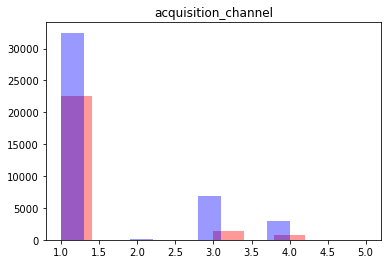

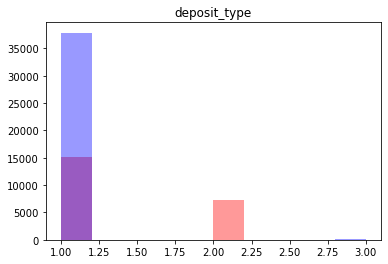

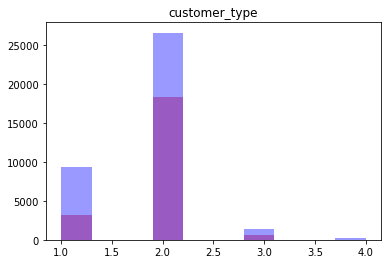

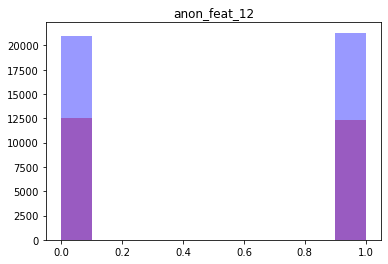

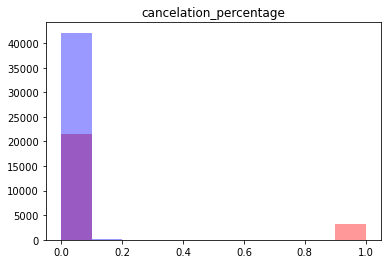

In [151]:
#Distribution of pos and neg labels by feautre, this is done again with normalization next
for col in X_num.columns:
    pos = X_num[col][y['cancelation'].astype(bool)]
    neg = X_num[col][~y['cancelation'].astype(bool)]
    plt.hist(pos,color ='r', alpha=0.4, label='Positive')
    plt.hist(neg, color='b', alpha=0.4, label ='Negative')
    plt.title(col)
    plt.show()

In [152]:
# features that seem with high corellation ['time_until_order'?,'order_year','order_day_of_month','agent','annot_feat_2,6,12','','','','','','',]
# features that apears strong ['annot_feat_9,10','deposit_type','agent']

id


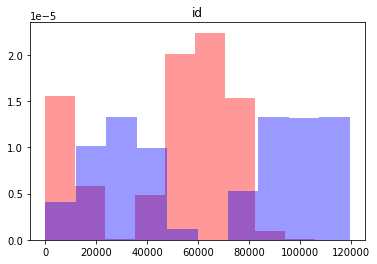

time_until_order


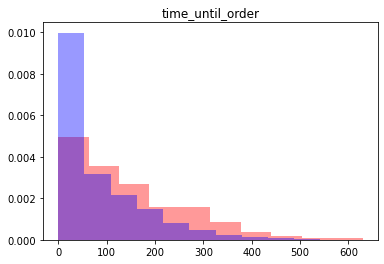

order_year


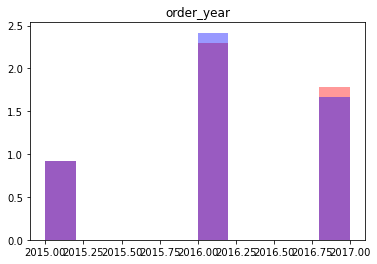

order_day_of_month


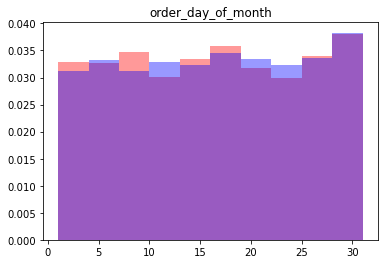

adults


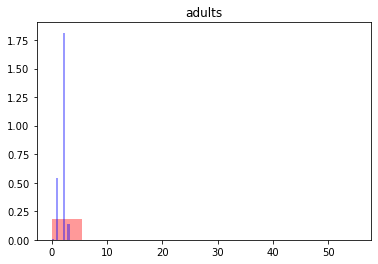

children


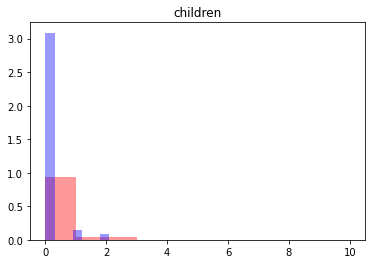

babies


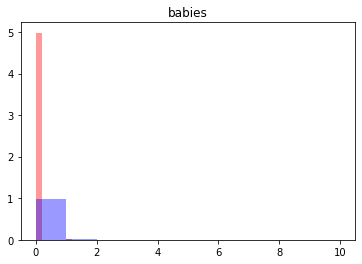

prev_canceled


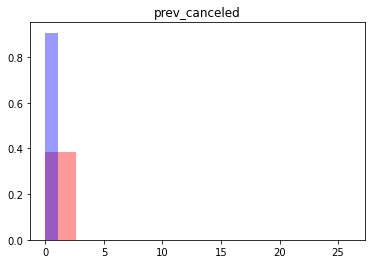

prev_not_canceled


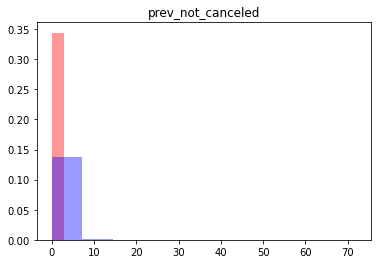

changes


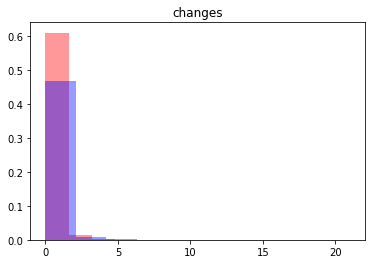

agent


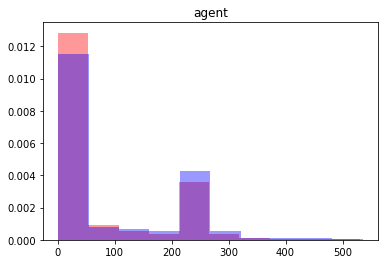

company


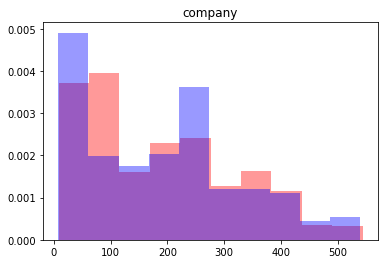

adr


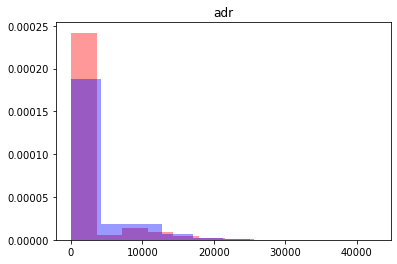

anon_feat_0


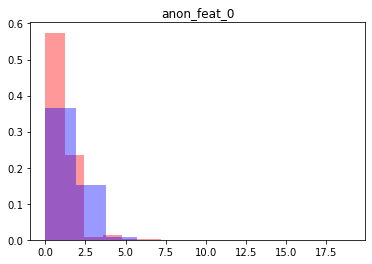

anon_feat_1


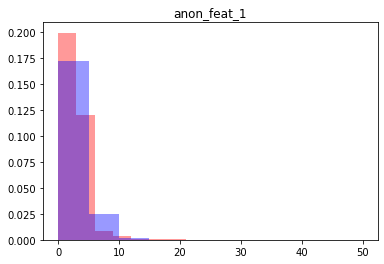

anon_feat_2


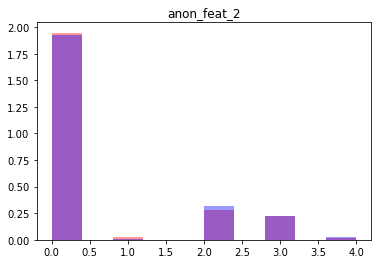

anon_feat_3


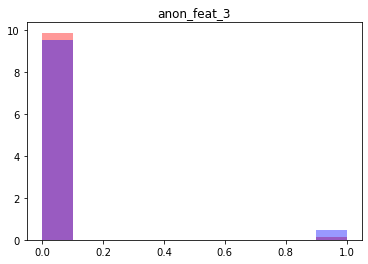

anon_feat_4


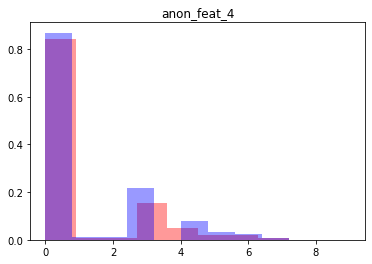

anon_feat_5


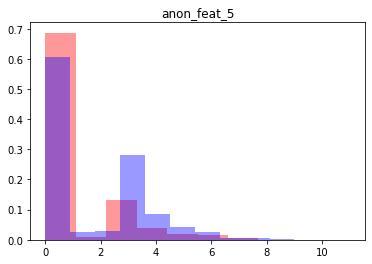

anon_feat_6


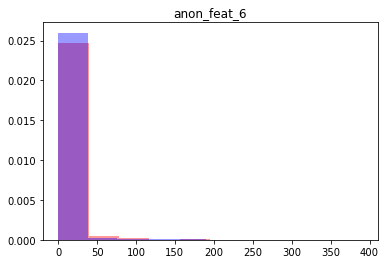

anon_feat_7


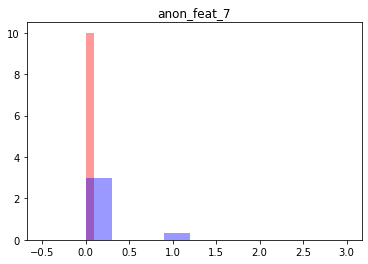

anon_feat_8


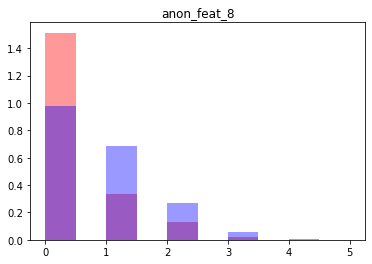

anon_feat_9


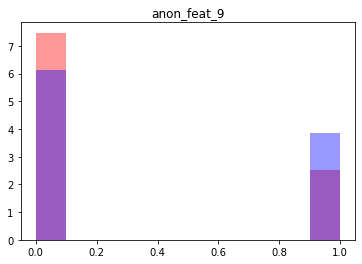

anon_feat_10


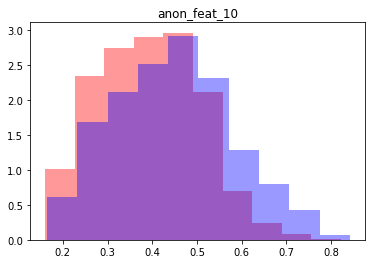

anon_feat_11


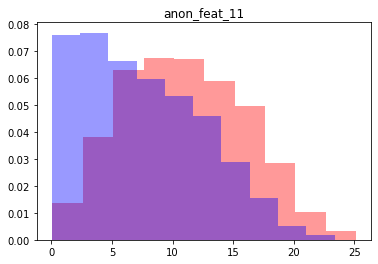

anon_feat_13


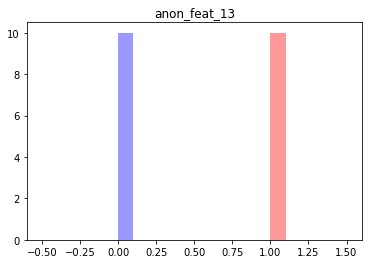

order_month


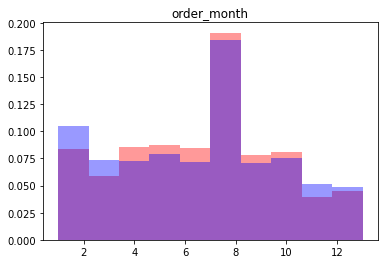

order_week


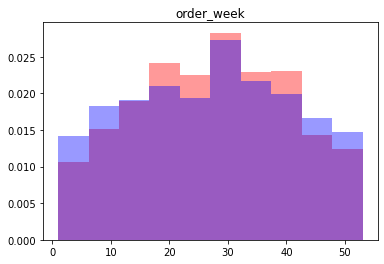

order_type


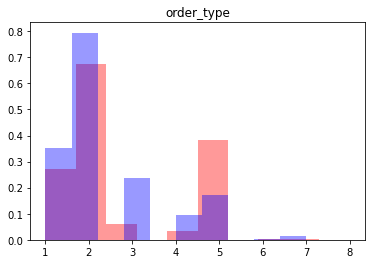

acquisition_channel


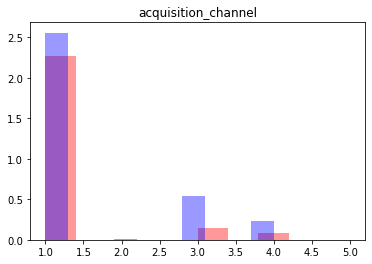

deposit_type


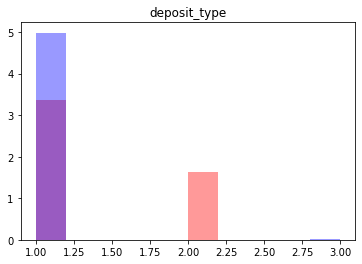

customer_type


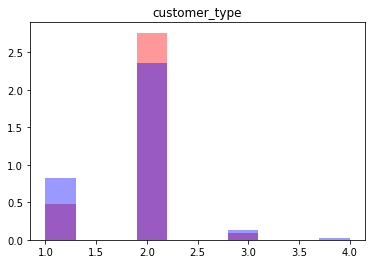

anon_feat_12


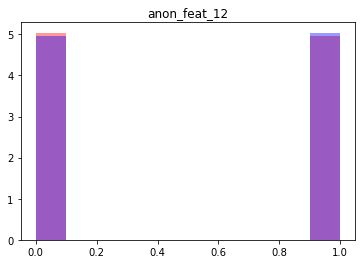

cancelation_percentage


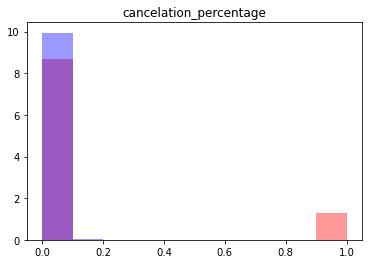

In [153]:
for col in X_num.columns:
    print(col)
    not_na = ~X_num[col].isna()
    pos = X_num[col][y['cancelation'].astype(bool)][not_na]
    neg = X_num[col][~y['cancelation'].astype(bool)][not_na]
    plt.hist(pos,color ='r', alpha=0.4, label='Positive', density = True)
    plt.hist(neg, color='b', alpha=0.4, label ='Negative', density = True)
    plt.title(col)
    plt.show()

# Handling outlayers

adults :  0.0005360652808386444
babies :  0.007743165167669307
children :  0.031508725951515874


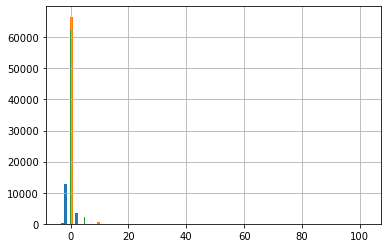

In [154]:
# 1. we will probably want to handle ['adults','children','babies','adr','annot_feat_0-1,6']
# 2. maybe we won't touch these features? because we can get the intuition that these outlayers will be important?
# ['prev_not_canceled',prev_canceled','changes','','']

out = ['adults','babies','children']
for col in out:
    z_scores = ((X_num[col]-X_num[col].mean())/X_num[col].std(ddof=0))
    z_scores.hist(bins=100)
    print(col, ": ",(z_scores>3.5).mean() )
    
# lets clear those 3 outlayers

## Log

<AxesSubplot:>

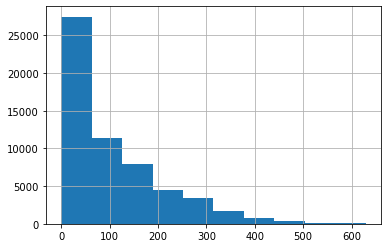

In [155]:
X_num['time_until_order'].hist()

In [156]:
# np.log(X_num[['time_until_order']]+1).hist(figsize=(10,10))
#check this, looks off

# 2 - preprocessing

In [157]:
X_train_copy = X_num.fillna(X_num.mean())

In [158]:
X_train_copy.isna().any()

id                        False
time_until_order          False
order_year                False
order_day_of_month        False
adults                    False
children                  False
babies                    False
prev_canceled             False
prev_not_canceled         False
changes                   False
agent                     False
company                   False
adr                       False
anon_feat_0               False
anon_feat_1               False
anon_feat_2               False
anon_feat_3               False
anon_feat_4               False
anon_feat_5               False
anon_feat_6               False
anon_feat_7               False
anon_feat_8               False
anon_feat_9               False
anon_feat_10              False
anon_feat_11              False
anon_feat_13              False
order_month               False
order_week                False
order_type                False
acquisition_channel       False
deposit_type              False
customer

In [159]:
X_train_copy['deposit_type']

72578    1.00000
66308    1.00000
25709    1.00000
40632    1.00000
38959    1.12436
          ...   
6265     1.00000
54886    1.00000
76820    1.00000
860      1.00000
15795    1.12436
Name: deposit_type, Length: 67156, dtype: float64

# Split numerical and categorial data of the test set


In [160]:
# Split numerical and categorial data of the test set

X_num_val = X_val.select_dtypes(include=[np.number])
X_categ_val = X_val.select_dtypes(exclude=[np.number])
print ('number of categorical features: ' ,len(X_categ_val.columns))
c1= X_categ_val.copy()

number of categorical features:  8


In [161]:
# Change categorial to numerical in the test set
# we can easily deal with 'order_month','order_week' by converting them to their corresponding numbers,
# and 'anon_feat_12' to binary values
months = {'January':1,'February':2,'March':3,'April': 4,'May': 5,'June': 6,'July': 7,'August': 8,'September': 9,'October': 10,'November': 11,'December': 12}
c1['order_month'].replace(months, inplace=True)
c1['order_week'] = c1['order_week'].str.slice(start=5).apply(pd.to_numeric)
c1['order_month'].fillna((c1['order_week']/4.3).apply(np.ceil), inplace = True)  #calc month for NA values from week, this isn't precise
c1['anon_feat_12'] = c1['anon_feat_12'].astype(int)

# we will probable want to use get_dummies for those, for now i'm changing it so we can take a look at correlations with lables
order_t = {'Offline TA/TO':1,'Online TA':2,'Direct':3,'Corporate':4,'Groups':5,'Aviation':6,'Complementary':7,'Undefined':8}
c1['order_type'].replace(order_t, inplace=True)
acq_c = {'TA/TO':1,'GDS':2,'Direct':3,'Corporate':4,'Undefined':5}
c1['acquisition_channel'].replace(acq_c, inplace=True)
dep = {'No Deposit':1,'Non Refund':2,'Refundable':3}
c1['deposit_type'].replace(dep, inplace=True)
cus_t = {'Transient-Party':1,'Transient':2,'Contract':3,'Group':4}
c1['customer_type'].replace(cus_t, inplace=True)
c1.info()
#joining data to numerical dataframe
#for now, I didn't handle Country so I didn't add it

X_num_val = X_num_val.join(c1.drop('country', axis=1))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 22386 entries, 23476 to 19170
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   order_month          22386 non-null  float64
 1   order_week           22386 non-null  int64  
 2   country              21286 non-null  object 
 3   order_type           22386 non-null  int64  
 4   acquisition_channel  22386 non-null  int64  
 5   deposit_type         20163 non-null  float64
 6   customer_type        19875 non-null  float64
 7   anon_feat_12         22386 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 1.5+ MB


In [163]:
X_num_val['cancelation_percentage'] = X_num_val['prev_canceled']/(X_num_val['prev_canceled']+X_num_val['prev_not_canceled'])
X_num_val['cancelation_percentage'].fillna(0, inplace = True)

In [169]:
X_val_copy =  X_num_val.fillna(X_num_val.mean())

# 3 - Modeling

In [164]:
#run PCA
pca = PCA()
data_for_pca = (X_train_copy - X_train_copy.mean())/(X_train_copy.std())
x_tr_pca = pca.fit_transform(data_for_pca)

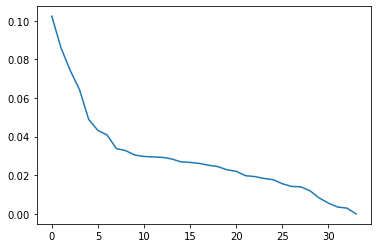

In [165]:
plt.plot(pca.explained_variance_ratio_)

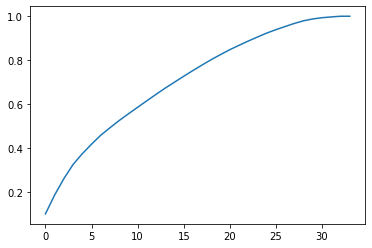

In [166]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [167]:
#run classifieres 
knn = KNeighborsClassifier()
lr = LogisticRegression()
ann = MLPClassifier()
rf = RandomForestClassifier()

clfs = [knn,lr,ann,rf]

In [168]:
for clf in clfs:
    print(clf)
    clf.fit(X_train_copy,y_train['cancelation'])
    print('test')
    plot_roc_curve(clf,X_val_copy,y_val['cancelation'])
    plt.show()
    print('train')
    plot_roc_curve(clf,X_train_copy,y_train['cancelation'])
    plt.show()
    print('test')
    plot_confusion_matrix(clf,X_val_copy,y_val['cancelation'])
    plt.show()
    print('train')
    plot_confusion_matrix(clf,X_train_copy,y_train['cancelation'])
    plt.show()

KNeighborsClassifier()
test


ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 33 while Y.shape[1] == 34